In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
#Load data: Load both the merged data and the original unaltered data 
merged_file = '../DataSet/merged_data2.csv'
data = pd.read_csv(merged_file, parse_dates =[2])

#market_file = '../DataSet/market_clean.csv'
#data = pd.read_csv(market_file, parse_dates =[1])

#news_file = '../DataSet/news_train_df.csv'
#news_data = pd.read_csv(news_file, parse_dates =[1])

In [3]:
#Eliminate recession data
data = data[data.time >= '2010-1-1']

# Word Embedding Using Subjects and Headlines

In [4]:
data = data.drop('headlineTag', axis = 1)
data = data.fillna(0)
data = data[data.headline != 0]
data = data.reset_index()

In [5]:
#Vectorize the subject lines and then perform svd on them to create new features
vectorizer = CountVectorizer()
vectorizer.fit(data.subjects)

X_subjects = vectorizer.transform(data.subjects)

n_comp = 10

svd = TruncatedSVD(n_components = n_comp)
svd.fit(X_subjects)
X_svd = svd.transform(X_subjects)
tempmat = pd.SparseDataFrame(X_svd)

for index in range(n_comp):
    name = 'subject_' + str(index)
    data[name] = tempmat.iloc[:,index]

var_subject = svd.explained_variance_ratio_
del vectorizer, svd, X_svd, tempmat

In [6]:
#Vectorize the subject lines and then perform svd on them to create new features
vectorizer = CountVectorizer()
vectorizer.fit(data.headline)

X_subjects = vectorizer.transform(data.headline)

n_comp = 10

svd = TruncatedSVD(n_components = n_comp)
svd.fit(X_subjects)
X_svd = svd.transform(X_subjects)
tempmat = pd.SparseDataFrame(X_svd)

for index in range(n_comp):
    name = 'headline_' + str(index)
    data[name] = tempmat.iloc[:,index]
    
var_headline = svd.explained_variance_ratio_
del vectorizer, svd, X_svd, tempmat

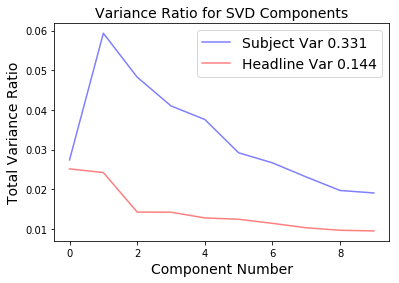

In [8]:
#Graph explained variance ratio for subject and headline svd components
x_vec = range(len(var_headline))
var_s = var_subject.sum()
var_h = var_headline.sum()

plt.plot(x_vec, var_subject, color = 'b', alpha = 0.5)
plt.plot(x_vec, var_headline, color = 'r', alpha = 0.5)
plt.xlabel('Component Number', fontsize = 14)
plt.ylabel('Total Variance Ratio', fontsize = 14)
plt.title('Variance Ratio for SVD Components', fontsize = 14)
plt.legend(['Subject Var %.3f'%var_s, 'Headline Var %.3f'%var_h], loc = 'upper right', fontsize = 14)
plt.savefig('VarianceRatio_embed_av.png', bbox = 'tight')
plt.show()

In [7]:
#Combine mean of news data information by day
data = data.groupby(['assetName','time']).mean()
data = data.reset_index(drop = False)

In [8]:
#Save compact data to file
compact_file = '../DataSet/compact_data_embed.csv'
data.to_csv(compact_file)

# Feature Engineering

In [9]:
#Create new features to help in modeling data

#Calculate asset name values
array_idx = dict(zip(data.assetName.unique(), np.arange(data.assetName.nunique())))
data['assetNameT'] = data['assetName'].map(array_idx)

#Calculate a rolling average of 5 and 10 days over the stock opening price
open5 = data.groupby('assetName')['open'].rolling(window = 5).mean()
open10 = data.groupby('assetName')['open'].rolling(window = 10).mean()

#Calculate daily log return
logr = np.log10(data.close/data.open)

#Return Prev10 Raw rolling average over 5 and 10 days
r5 = data.groupby('assetName')['returnsOpenPrevRaw10'].rolling(window = 5).mean()
r10 = data.groupby('assetName')['returnsOpenPrevRaw10'].rolling(window = 10).mean()

#Sentiment class average over 5 and 10 data points
sent5 = data.groupby('assetName')['sentimentClass'].rolling(window = 5).mean()
sent10 = data.groupby('assetName')['sentimentClass'].rolling(window = 10).mean()

#Insert data into dataframe for use in modeling
data['open5'] = open5.values
data['open10'] = open10.values
data['r5'] = r5.values
data['r10'] = r10.values
data['logr'] = logr
data['sent5'] = sent5.values
data['sent10'] = sent10.values

In [10]:
#data = data.drop(['assetCode', 'assetName', 
 #              'sourceTimestamp', 'firstCreated', 'sourceId', 
 #              'provider', 'subjects', 'audiences', 'assetCodes', 
  #             'Unnamed: 0', 'Unnamed: 0.1', 'marketCommentary', 'headline'], axis = 1)
#['assetCode', 'assetName', 
#               'sourceTimestamp', 'firstCreated', 'sourceId', 
#               'provider', 'subjects', 'audiences', 'assetCodes', 
#               'Unnamed: 0', 'Unnamed: 0.1', 'marketCommentary', 'headline']

In [11]:
#Set up X and y for modeling
X = data.drop(['marketCommentary', 'Unnamed: 0', 'Unnamed: 0.1',
            'bodySize', 'companyCount', 'assetName'], axis = 1)
X = X.dropna(axis = 0)
y = (X.returnsOpenNextMktres10 >= 0)
y = y.astype(int)

#Set up additional parameters to calculate final metric used in Two Sigma competition
universe = X.dropna(axis = 0).universe
r = X.dropna(axis = 0).returnsOpenNextMktres10
day = X.dropna(axis = 0).time.dt.date
#asset_name = X.dropna(axis = 0).assetName

X = X.drop(['returnsOpenNextMktres10', 'universe', 'time'], axis = 1)

In [10]:
#Normalize data
X_mean = X.mean(axis = 0)
X_std = X.std(axis = 0)

X = (X-X_mean)/X_std

In [12]:
#Create train and test sets
X_train, X_test, y_train, y_test, _, univ_test, _, r_test, _, day_test = \
       train_test_split(X, y, universe, r, day, test_size = 0.3, random_state = 42)
del X, y, universe, r, day

In [13]:
print(len(y_train))
print(len(y_test))

527878
226234


# XGBoost Classifier

In [14]:
#Set up model and determine best parameters for XGBClassifier
gb = XGBClassifier()
#params = {'n_estimators': [200, 500, 1000, 2000, 4000],
#          'max_depth': [4, 6, 8, 10],
#          'learning_rate': [.001, .01, 0.1, 0.3],
#          'booster': ['gbtree', 'gblinear', 'dart']}
params = {'booster': 'gbtree',
          'learning_rate': 0.1,
          'max_depth': 6,
           'n_estimators': 100,
          'n_jobs': 4}
#gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1)

#Preform grid search to find best fit parameters using XGBClassifier
#gb_cv.fit(X_train, y_train)

#Show the best parameters and best score value determined from the grid search
#print(gb_cv.best_params_)
#print(gb_cv.best_score_)

In [15]:
#Initialize model with optimized parameters
model = XGBClassifier(**params)

In [16]:
%%time
#Fit model to training data
gb_model = model.fit(X_train, y_train)

Wall time: 2min 53s


In [17]:
#Collection prediction values for classification
y_pred = model.predict_proba(X_test)
predictions = [round(value[1]) for value in y_pred]
print(y_pred[20:30])

[[0.37519658 0.6248034 ]
 [0.40939736 0.59060264]
 [0.50654066 0.49345937]
 [0.42715704 0.57284296]
 [0.5326874  0.46731254]
 [0.37578392 0.6242161 ]
 [0.44246602 0.557534  ]
 [0.4937359  0.5062641 ]
 [0.5121314  0.4878686 ]
 [0.4232509  0.5767491 ]]


In [18]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5867


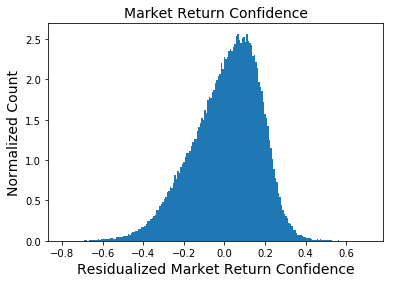

In [22]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_pred[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_embed_av.png', bbox = 'tight')
plt.show()

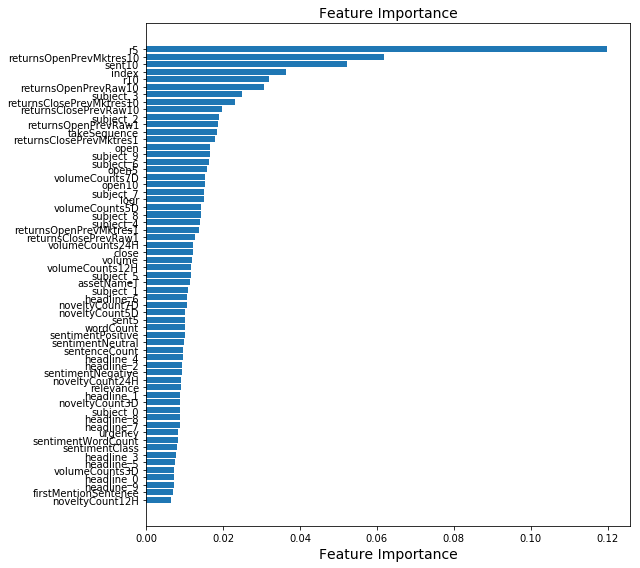

In [21]:
#Display bar graph of feature importance in model
features = X_train.columns
feat_imp = model.feature_importances_
feat = pd.DataFrame()
feat['feature'] = features
feat['importance'] = feat_imp
feat = feat.sort_values('importance')

wide = np.arange(len(feat_imp))
plt.figure(figsize = (9,8))
plt.barh(wide, feat['importance'])
plt.yticks(wide, feat['feature'])
plt.xlabel('Feature Importance', fontsize = 14)
plt.title('Feature Importance', fontsize = 14)
plt.tight_layout()
plt.savefig('FeatureImportance_embed_av.png', bbox = 'tight')
plt.show()

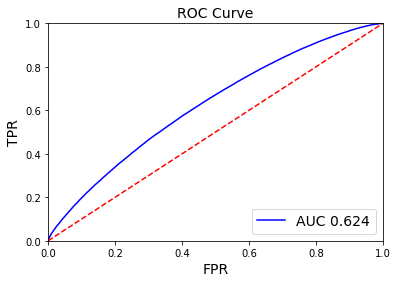

In [23]:
#Plot ROC curve for XGBClassifier model
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
auc = roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_embed_av.png', bbox = 'tight')
plt.show()

In [24]:
#Calculate the metric used Two Sigma competition for scoring
def two_sigma_score(y_r, univ_test, r_test):
    #Clip outliers for the returnsOpenNextMktres10 data
    r_test2 = r_test.clip(-1,1)
    
    #Calculate scoring metric
    y_int = y_r*univ_test*r_test2
    df = pd.DataFrame()

    df['day'] = day_test[y_int != 0]
    df['y_int'] = y_int[y_int != 0]

    y_i = df.groupby('day').sum().values.flatten()
    mean_i = np.mean(y_i)
    std_i = np.std(y_i)

    score_ts = mean_i/std_i

    return score_ts

In [25]:
score_gb = two_sigma_score(y_r, univ_test, r_test)
print('Score using XGBClassifier %.4f'%(score_gb))

Score using XGBClassifier 0.9241


# Light GBM Classsification

In [26]:
#Perform light gbm
train_data = lgb.Dataset(X_train, label=y_train)
param = {'num_leaves':100,
         'objective':'binary',
         'max_depth':6,
         'learning_rate':0.1,
         'max_bin':200}

lgb_model = lgb.train(param, train_data, 50)
ypred_lgb = lgb_model.predict(X_test)

In [27]:
predictions2 = [round(value) for value in ypred_lgb]

In [28]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions2)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5742


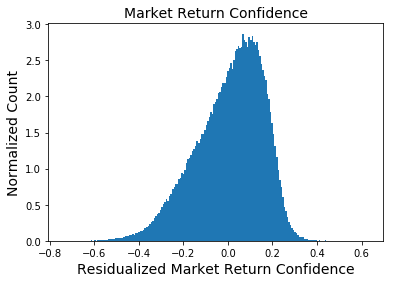

In [29]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = ypred_lgb*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_lgb_embed_av.png', bbox = 'tight')
plt.show()

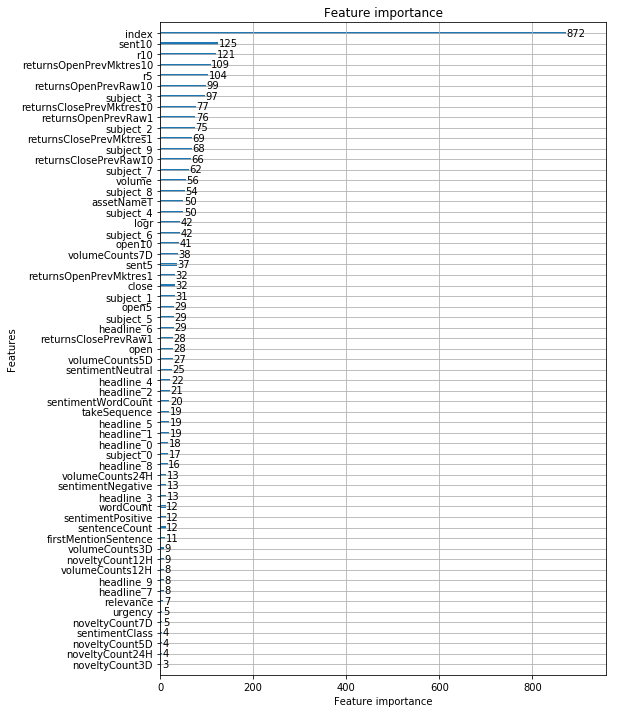

In [30]:
#Display bar graph of feature importance in model
lgb.plot_importance(lgb_model, figsize=(8,12))

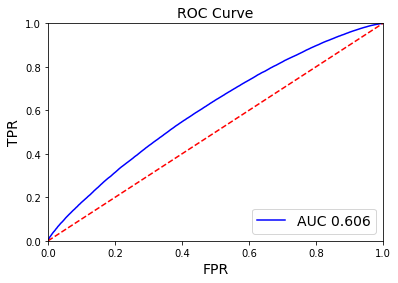

In [31]:
#Calculate ROC curve for light gbm model
fpr, tpr, thresholds = roc_curve(y_test, ypred_lgb)
auc = roc_auc_score(y_test, ypred_lgb)

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_lgb_embed_av.png', bbox = 'tight')
plt.show()

In [32]:
#Calculate the metric used Two Sigma competition for scoring
y_r = ypred_lgb*2 - 1
score_lb = two_sigma_score(y_r, univ_test, r_test)
print('Score using Light GBM %.4f'%(score_lb))

Score using Light GBM 0.8247


# Naive Bayes Classification

In [33]:
#Perform Naive Bayes algorithm on data
from sklearn.naive_bayes import GaussianNB
data2 = data.dropna(how = 'any', axis = 0)
X2 = data2[features]
y2 = (data2.returnsOpenNextMktres10 >= 0).values
y2 = y2.astype(int)

del data2

X_train2, X_test2, y_train2, y_test2 = \
       train_test_split(X2, y2, test_size = 0.3, random_state = 42)

del X2, y2

nb = GaussianNB()
nb.fit(X_train2, y_train2)
y_pred_nb = nb.predict(X_test2)

In [34]:
#Calculate accuracy score for the predictions
y_pred_nb = nb.predict_proba(X_test2)
predictions_nb = [round(value[1]) for value in y_pred_nb]

accuracy = accuracy_score(y_test2, predictions_nb)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5052


# Ensemble Stacking Classification

In [35]:
#Produce Instances of model to use in stacking
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators = 10)
model2 = GaussianNB()
model3 = XGBClassifier(**params)
lr = LogisticRegression(solver = 'lbfgs')

smodel = StackingCVClassifier(classifiers = [model1, model2, model3],\
                              use_probas = True,\
                              meta_classifier = lr)

In [36]:
#Calculate cross validation scores using stacking classifier

print('3-fold cross validation score')
for clf, label in zip([model1, model2, model3, smodel], 
                      ['Random Forest', 
                       'Naive Bayes', 
                       'XGBoost',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation score
Accuracy: 0.53 (+/- 0.00) [Random Forest]
Accuracy: 0.51 (+/- 0.00) [Naive Bayes]
Accuracy: 0.59 (+/- 0.00) [XGBoost]
Accuracy: 0.59 (+/- 0.00) [StackingClassifier]


In [37]:
#Fit the stacking classifier and evaluate results
stack_fit = smodel.fit(X_train.values, y_train.values)

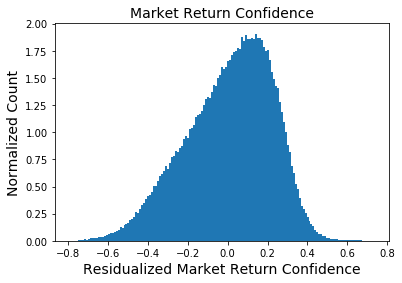

In [38]:
y_pred_stack = smodel.predict_proba(X_test.values)
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r_stack = y_pred_stack[:,1]*2 - 1
plt.hist(y_r_stack, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_Stack_embed.png', bbox = 'tight')
plt.show()

In [39]:
#Calcaulate two sigma score for the stacking models
y_r = y_pred_stack[:,1]*2 - 1
score_stack = two_sigma_score(y_r, univ_test, r_test)
print('Score using Stacking Models %.4f'%(score_stack))

Score using Stacking Models 0.9417


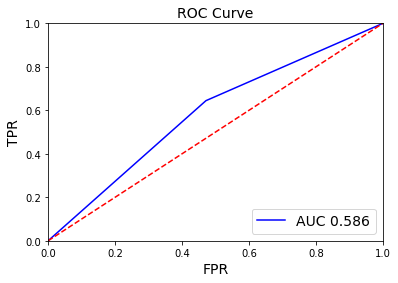

In [40]:
predictions_stack = [round(value) for value in y_pred_stack[:,1]]

#Calculate ROC curve for stack model
fpr, tpr, thresholds = roc_curve(y_test, predictions_stack)
auc = roc_auc_score(y_test, predictions_stack)

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_stack__embed.png', bbox = 'tight')
plt.show()